## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading Data

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. We will try to predict if a person has diabetes given certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [2]:
diabetes = pd.read_csv('data/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


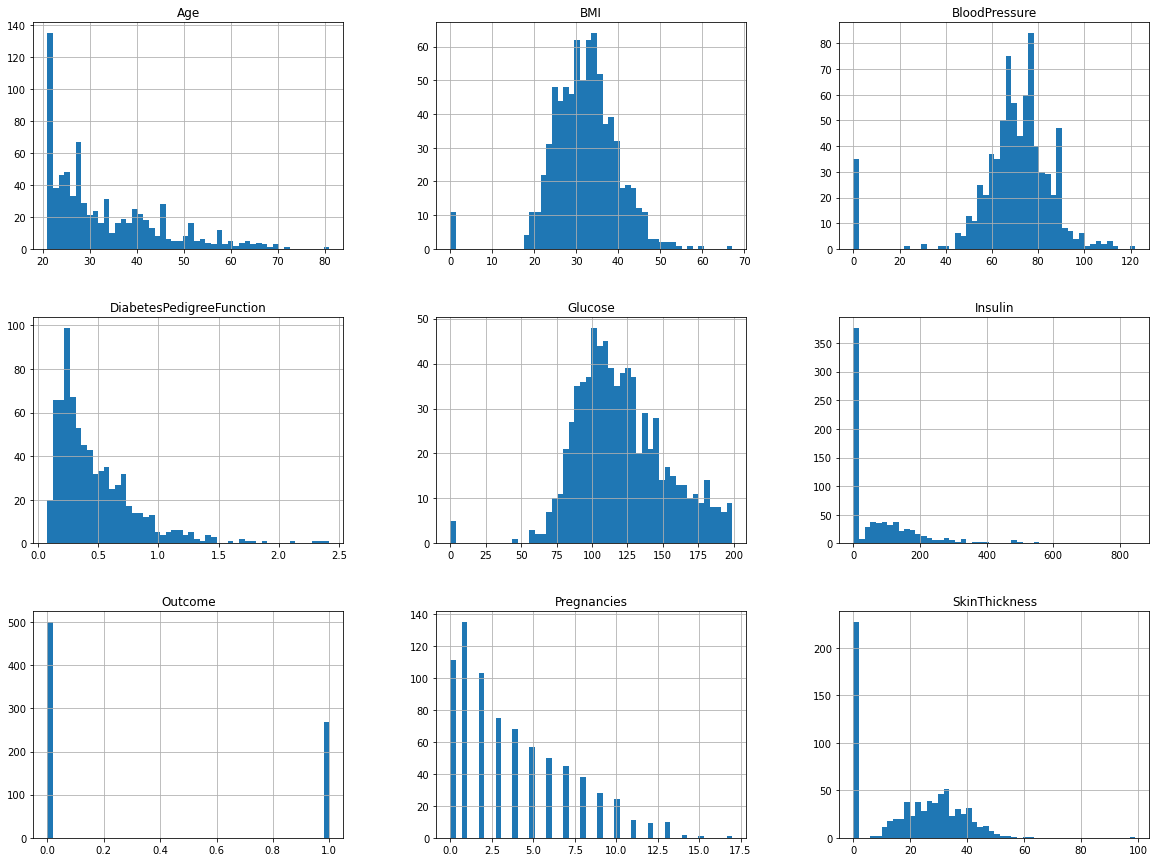

In [5]:
diabetes.hist(bins=50,figsize=(20,15));

In [6]:
diabetes.query('BMI==0 | BloodPressure==0 | Glucose ==0').shape

(44, 9)

We can see that 44 entries are mislabelled with BMI, blood pressure or glucose as 0.

## Separating Training Set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_set, test_set = train_test_split(diabetes,test_size=0.2,random_state=42)

Looking for Correlations.

In [9]:
corr_matrix = diabetes.corr()

In [10]:
corr_matrix['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

Seeing correlation through scatter matrix. Selecting only highest correlated attributes as otherwise would show too many plots.

In [11]:
from pandas.plotting import scatter_matrix

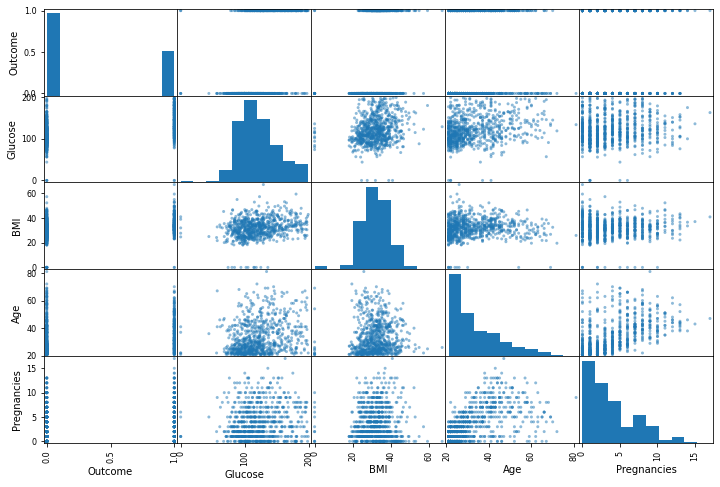

In [12]:
attributes = ['Outcome','Glucose','BMI','Age','Pregnancies']
scatter_matrix(diabetes[attributes],figsize=(12,8));

The most promising attribute to predict the presence of diabetes is glucose so we zoom in the correlation scatterplot.

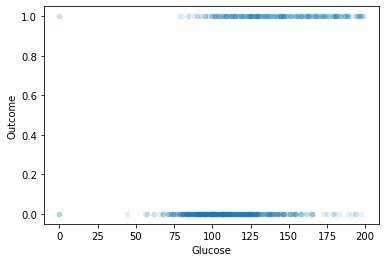

In [13]:
diabetes.plot(kind='scatter',x='Glucose',y='Outcome',alpha=0.1);

# Preparing the Data for Machine Learning

Separating predictors and labels.

In [14]:
diabetes = train_set.drop('Outcome',axis=1)
diabetes_labels = train_set['Outcome'].copy()

## Data Cleaning

To handle entries where 0 is an invalid number we will use a SimpleImputer where we'll specify it to replace 0 for median values. But since 0 is a valid value for others atributes, we create different pipelines to handle each type of column.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [16]:
invalid_zero_pipeline = Pipeline([
    ('imputer',SimpleImputer(missing_values=0,strategy='median')),
    ('std_scaler',StandardScaler())
])

valid_zero_pipeline = Pipeline([
    ('std_scaler',StandardScaler())
])

Using ColumnTransformer to handle each column differently.

In [17]:
from sklearn.compose import ColumnTransformer

In [18]:
valid_zero_attributes = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
invalid_zero_attributes = ['BMI', 'BloodPressure', 'Glucose']

In [19]:
full_pipeline = ColumnTransformer([
    ('valid_zero',valid_zero_pipeline,valid_zero_attributes),
    ('invalid_zero',invalid_zero_pipeline,invalid_zero_attributes)
])

diabetes_prepared = full_pipeline.fit_transform(diabetes)

# Selecting and Training a Model

## Training and Evaluating on the Training Set

#### Training a Logistic Regression model.

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
log_reg = LogisticRegression()
log_reg.fit(diabetes_prepared,diabetes_labels)

LogisticRegression()

Trying on a few instances from the training set.

In [22]:
some_data = diabetes.iloc[:5]
some_labels = diabetes_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:',log_reg.predict(some_data_prepared))
print('Labels:',list(some_labels))

Predictions: [0 0 0 1 1]
Labels: [0, 1, 0, 0, 1]


Using a confusion matrix to evaluate the accuracy of a classification.

In [23]:
from sklearn.metrics import classification_report,confusion_matrix

In [24]:
print(classification_report(log_reg.predict(some_data_prepared), list(some_labels)))
print(confusion_matrix(log_reg.predict(some_data_prepared), list(some_labels)))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5

[[2 1]
 [1 1]]


Now in the whole dataset.

In [25]:
diabetes_predictions = log_reg.predict(diabetes_prepared)

print(classification_report(diabetes_predictions,list(diabetes_labels)))
print(confusion_matrix(diabetes_predictions,list(diabetes_labels)))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       451
           1       0.55      0.72      0.63       163

    accuracy                           0.77       614
   macro avg       0.72      0.76      0.73       614
weighted avg       0.80      0.77      0.78       614

[[356  95]
 [ 45 118]]


#### Training a Decision Tree classifier.

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
tree_clf = DecisionTreeRegressor()
tree_clf.fit(diabetes_prepared,diabetes_labels)

DecisionTreeRegressor()

In [28]:
diabetes_predictions = tree_clf.predict(diabetes_prepared)

print(classification_report(diabetes_predictions,list(diabetes_labels)))
print(confusion_matrix(diabetes_predictions,list(diabetes_labels)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       401
         1.0       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614

[[401   0]
 [  0 213]]


As we can see the Decision Tree classifier has badly overfit the training data.

## Better Evalutation Using Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
scores = cross_val_score(tree_clf,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)

In [31]:
def display_scores(scores):
    print('Scores:',scores)
    print('Mean:',scores.mean())
    print('Standard deviation:',scores.std())

In [32]:
display_scores(scores)

Scores: [0.60869565 0.51612903 0.6        0.55319149 0.70588235 0.61904762
 0.35294118 0.52631579 0.66666667 0.65217391]
Mean: 0.5801043691436893
Standard deviation: 0.09515802659799523


Computing the same scores for Logistic Regression.

In [33]:
log_scores = cross_val_score(log_reg,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)
display_scores(log_scores)

Scores: [0.6        0.63414634 0.75675676 0.59459459 0.54054054 0.7027027
 0.48484848 0.58536585 0.61111111 0.68421053]
Mean: 0.6194276911991932
Standard deviation: 0.07534301006298288


The Decision Tree model is overfitting so badly that it performs worse than the Logistic Regression model.

#### Training a Random Forest Classifier.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
forest_clf = RandomForestClassifier()
forest_clf.fit(diabetes_prepared, diabetes_labels)

RandomForestClassifier()

In [36]:
forest_scores = cross_val_score(forest_clf,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)
display_scores(forest_scores)

Scores: [0.68292683 0.66666667 0.66666667 0.66666667 0.56410256 0.69767442
 0.57142857 0.58536585 0.68292683 0.65      ]
Mean: 0.6434425066330909
Standard deviation: 0.047512040848799335


#### Training a Support Vector Machine.

In [37]:
from sklearn import svm

In [38]:
spm_clf = svm.SVC()
spm_clf.fit(diabetes_prepared, diabetes_labels)

SVC()

In [39]:
spm_scores = cross_val_score(spm_clf,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)
display_scores(spm_scores)

Scores: [0.56410256 0.65       0.71794872 0.63414634 0.55555556 0.61904762
 0.46666667 0.57894737 0.66666667 0.65      ]
Mean: 0.6103081499872258
Standard deviation: 0.06731082750604177


#### Training a K-nearest Neighbors Classifier

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
kn_clf = KNeighborsClassifier(n_neighbors=5)
kn_clf.fit(diabetes_prepared, diabetes_labels)

KNeighborsClassifier()

In [42]:
kn_scores = cross_val_score(kn_clf,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)
display_scores(kn_scores)

Scores: [0.47619048 0.61904762 0.7804878  0.5        0.58536585 0.54054054
 0.58823529 0.68181818 0.65       0.64864865]
Mean: 0.6070334418899699
Standard deviation: 0.08556965840357815


#### Training a Naive Bayes Classifier 

In [43]:
from sklearn.naive_bayes import GaussianNB

In [44]:
gnb_clf = GaussianNB()
gnb_clf.fit(diabetes_prepared, diabetes_labels)

GaussianNB()

In [45]:
gnb_scores = cross_val_score(gnb_clf,diabetes_prepared,diabetes_labels,scoring='f1',cv=10)
display_scores(gnb_scores)

Scores: [0.59090909 0.63636364 0.76923077 0.57142857 0.56410256 0.69767442
 0.58823529 0.57777778 0.64864865 0.61538462]
Mean: 0.6259755386567971
Standard deviation: 0.06178801113667592


## Fine-Tuning the Model

The Random Forest classifier showed the highest f1-score so we will choose it as our model to fine tune.

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

In [48]:
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf,param_grid,cv=5,scoring='f1',return_train_score=True)

In [49]:
grid_search.fit(diabetes_prepared,diabetes_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='f1')

In [50]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

Since 30 is the maximum value evaluated we can try searching again with higher values.

In [55]:
param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [30, 50,100], 'max_features': [2, 3, 4]},
    ]

grid_search = GridSearchCV(forest_clf,param_grid,cv=5,scoring='f1',return_train_score=True)
grid_search.fit(diabetes_prepared,diabetes_labels)

grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

## Evaluating on the Test Set

In [56]:
final_model = grid_search.best_estimator_

X_test = test_set.drop('Outcome',axis=1)
y_test = test_set['Outcome'].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [57]:
final_predictions = final_model.predict(X_test_prepared)

print(classification_report(final_predictions,list(y_test)))
print(confusion_matrix(final_predictions,list(y_test)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        96
           1       0.69      0.66      0.67        58

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

[[79 17]
 [20 38]]


Our final Random Forest correctly predicts 80% of the time when the person doesn't have diabetes and 69% when the person has diabetes.